In [62]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython import display
from collections import Counter
import optuna



In [50]:
# Hyperparameters
learning_rate = 0.01
gamma = 0.99
epsilon = 0.1

In [51]:
# Environment setup
env = gym.make('FrozenLake-v1', is_slippery=False)
n_actions = env.action_space.n
n_states = env.observation_space.n

In [52]:
# Neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(n_states, n_actions)

    def forward(self, x):
        return self.fc(x)

In [53]:
# Initialize model, optimizer, and loss function
device = torch.device("mps")
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

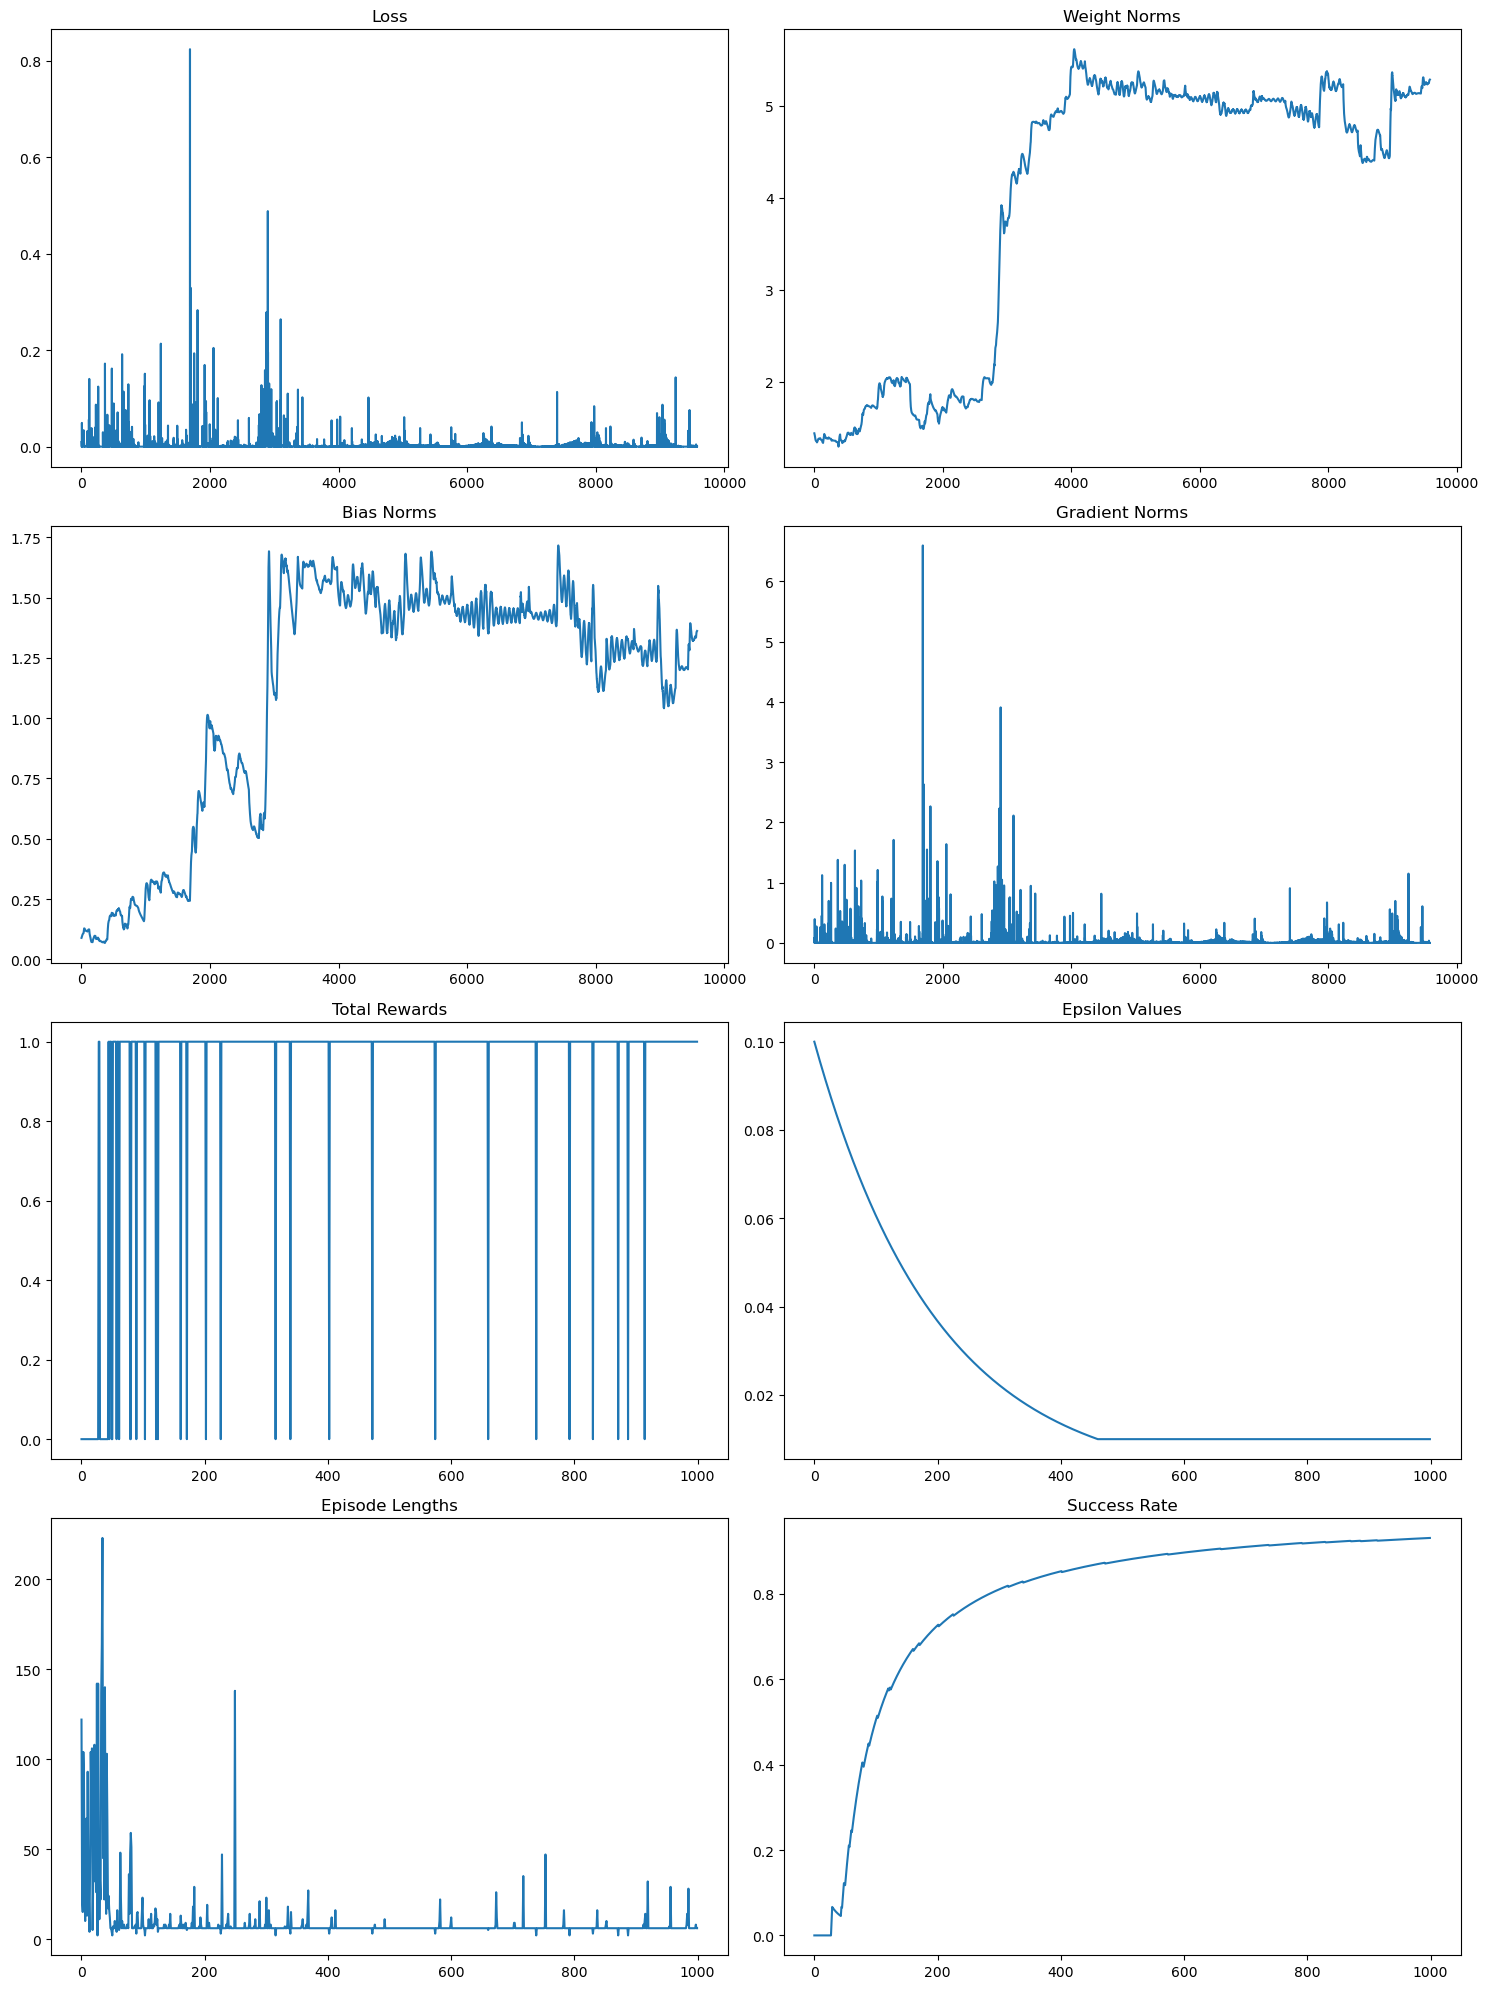

In [54]:
# Training loop
# Initialize lists to store metrics
losses = []
weight_norms = []
bias_norms = []
grad_norms = []
total_rewards = []
epsilon_values = []
episode_lengths = []
successful_episodes = 0
success_rate = []

plot_update_frequency = 50  # Update plots every 50 episodes, adjust as needed
num_episodes = 1000
# Training loop
for episode in range(num_episodes):
    state = env.reset()[0]
    done = False
    total_reward = 0
    episode_length = 0


    while not done:
        state_tensor = torch.FloatTensor(np.eye(n_states)[int(state)]).to(device)
        q_values = model(state_tensor)
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            action = torch.argmax(q_values).item()
        
        # (0, 0.0, False, False, {'prob': 1.0})
        next_state, reward, done, _, _ = env.step(action)

        next_state_tensor = torch.FloatTensor(np.eye(n_states)[next_state]).to(device)
        next_q_values = model(next_state_tensor)

        max_next_q = torch.max(next_q_values)
        q_target = reward + gamma * max_next_q * (1 - done)
        q_val = q_values[action]

        loss = loss_fn(q_val.view(1).cpu(), torch.tensor([q_target]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state

        # Calculate and store loss
        losses.append(loss.item())

        # Calculate and store weight and bias norms
        weight_norm = sum(torch.norm(param)**2 for param in model.parameters() if param.dim() > 1)
        bias_norm = sum(torch.norm(param)**2 for param in model.parameters() if param.dim() == 1)
        weight_norms.append(weight_norm.item())
        bias_norms.append(bias_norm.item())

        # Calculate and store gradient norms
        grad_norm = sum(torch.norm(param.grad)**2 for param in model.parameters() if param.grad is not None)
        grad_norms.append(grad_norm.item())
        
        # Accumulate reward
        total_reward += reward
        # Increment episode length
        episode_length += 1

        if done and reward > 0:  # Assuming a positive reward indicates success
            successful_episodes += 1


    # Store total reward and epsilon value for the episode
    total_rewards.append(total_reward)
    epsilon_values.append(epsilon)
    episode_lengths.append(episode_length)
    success_rate.append(successful_episodes / (episode + 1))  # Calculate success rate



    # Decay epsilon
    if epsilon > 0.01:
        epsilon *= 0.995

    # Update plots at specified frequency
    if episode % plot_update_frequency == 0 or episode == num_episodes - 1:
        # Plotting
        display.clear_output(wait=True)
        plt.figure(figsize=(15, 20))  # Adjust the figure size as needed
        
        # Subplot for Loss
        plt.subplot(4, 2, 1)
        plt.plot(losses)
        plt.title('Loss')
        
        # Subplot for Weight Norms
        plt.subplot(4, 2, 2)
        plt.plot(weight_norms)
        plt.title('Weight Norms')
        
        # Subplot for Bias Norms
        plt.subplot(4, 2, 3)
        plt.plot(bias_norms)
        plt.title('Bias Norms')
        
        # Subplot for Gradient Norms
        plt.subplot(4, 2, 4)
        plt.plot(grad_norms)
        plt.title('Gradient Norms')
        
        # Subplot for Total Rewards
        plt.subplot(4, 2, 5)
        plt.plot(total_rewards)
        plt.title('Total Rewards')
        
        # Subplot for Epsilon Values
        plt.subplot(4, 2, 6)
        plt.plot(epsilon_values)
        plt.title('Epsilon Values')
        
        # Subplot for Episode Lengths
        plt.subplot(4, 2, 7)
        plt.plot(episode_lengths)
        plt.title('Episode Lengths')
        
        # Subplot for Success Rate
        plt.subplot(4, 2, 8)
        plt.plot(success_rate)
        plt.title('Success Rate')
        
        plt.tight_layout()
        display.display(plt.gcf())
        plt.close()

# Close the environment
env.close()

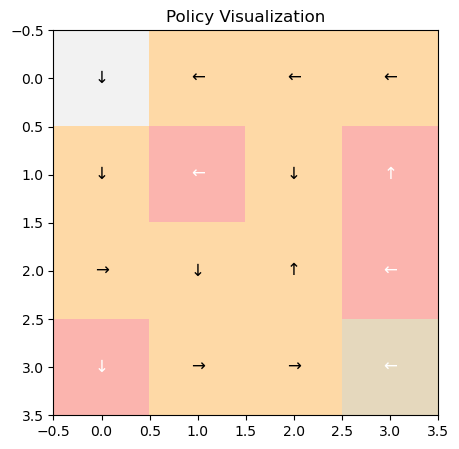

In [69]:
# Convert env.desc to a string format
desc = env.desc.astype(str)

# Create a color map for the grid
color_map = {'S': 1.0, 'F': 0.5, 'H': 0.0, 'G': 0.75}
grid_colors = np.vectorize(color_map.get)(desc)

# Extracting the policy from the model
policy = np.array([torch.argmax(model(torch.FloatTensor(np.eye(env.observation_space.n)[s]).to(device))).item() for s in range(env.observation_space.n)])

# Mapping actions to symbols for visualization
action_symbols = {0: '←', 1: '↓', 2: '→', 3: '↑'}
policy_symbols = np.vectorize(action_symbols.get)(policy)

# Reshape for grid visualization
policy_grid = policy_symbols.reshape(env.desc.shape)

# Plotting the policy grid
plt.figure(figsize=(5, 5))
plt.imshow(grid_colors, cmap='Pastel1', interpolation='nearest')
for i in range(desc.shape[0]):
    for j in range(desc.shape[1]):
        cell_color = 'white' if desc[i, j] in ['H', 'G'] else 'black'
        plt.text(j, i, policy_grid[i, j], ha='center', va='center', fontsize=12, color=cell_color)
plt.title('Policy Visualization')
plt.show()

In [57]:
env.desc


array([[b'S', b'F', b'F', b'F'],
       [b'F', b'H', b'F', b'H'],
       [b'F', b'F', b'F', b'H'],
       [b'H', b'F', b'F', b'G']], dtype='|S1')

In [61]:
def analyze_failures(env, model, num_episodes=100):
    failed_states = []
    for _ in range(num_episodes):
        state = env.reset()[0]
        done = False
        while not done:
            action = torch.argmax(model(torch.FloatTensor(np.eye(env.observation_space.n)[state]).to(device))).item()
            next_state, reward, done, _, _ = env.step(action)
            if done and reward == 0:  # Check if the episode ended without success
                failed_states.append(state)
            state = next_state
    return failed_states

# Analyze failures
failed_states = analyze_failures(env, model)
print("Failure States: ", set(failed_states))

Failure States:  set()


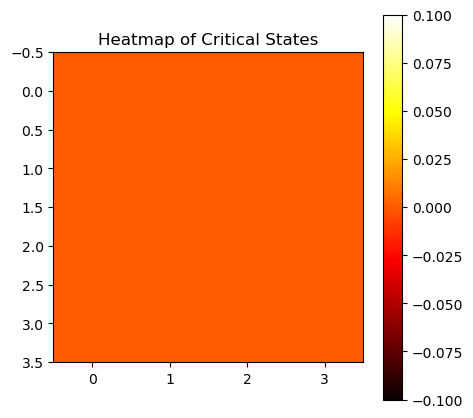

In [63]:
def plot_heatmap(env, state_counts):
    grid_counts = np.zeros(env.desc.shape)
    for state, count in state_counts.items():
        x, y = np.unravel_index(state, env.desc.shape)
        grid_counts[x, y] = count

    plt.figure(figsize=(5, 5))
    plt.imshow(grid_counts, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.title('Heatmap of Critical States')
    plt.show()

# Count occurrences of each state in failure cases
state_counts = Counter(failed_states)

# Plot heatmap
plot_heatmap(env, state_counts)
